In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from scipy.stats import ranksums

import glob
import os
import matplotlib.pyplot as plt

from modules.utilities import *
from modules.constants import *
from modules import CliffsDelta
from scipy.stats import shapiro
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio

plt.rcParams.update(mpl_params)
pio.templates.default = "custom_matplotlib_like"

TOPIC_DIR = "./Outputs/BERTopic/Topics"
DATA_DIR = "./Outputs/PerformancePRs"

In [2]:
type_df = read_aidev(FileName.POP_PR_TASK_TYPE)
perf_df = pd.read_csv(os.path.join(DATA_DIR, "POP_PULL_Requests_LLM_filtered_final.csv"))

In [3]:
# Merge task type information from type_df to perf_df based on pr id
perf_df = perf_df.merge(type_df[['id', 'type']], left_on='id', right_on='id', how='left')
perf_df

,id,number,title,body,agent,user_id,user,state,created_at,closed_at,merged_at,repo_id,repo_url,html_url,type
0,3164503419,40,Fix Claude animation flickering with vt10x-ins...,## 🎯 Problem: Claude's Thinking Animation Caus...,Claude_Code,2891702,hjanuschka,closed,2025-06-20T22:47:18Z,2025-06-21T11:51:22Z,NaN,1002552148,https://api.github.com/repos/amantus-ai/vibetu...,https://github.com/amantus-ai/vibetunnel/pull/40,fix
1,3273233066,1037,feat: implement comprehensive species tracking...,## Summary\nThis PR implements a comprehensive...,Claude_Code,7030001,tphakala,closed,2025-07-29T11:21:11Z,2025-07-29T13:49:45Z,2025-07-29T13:49:45Z,707764474,https://api.github.com/repos/tphakala/birdnet-go,https://github.com/tphakala/birdnet-go/pull/1037,feat
2,3219880512,10340,feat(backend): Integrate GCS file storage with...,## Summary\n\nThis PR introduces a complete cl...,Claude_Code,76959103,majdyz,closed,2025-07-10T15:52:56Z,2025-07-18T03:20:54Z,2025-07-18T03:20:54Z,614765452,https://api.github.com/repos/Significant-Gravi...,https://github.com/Significant-Gravitas/AutoGP...,feat
3,2876006908,3375,Improve list and collection materializers perf...,# Optimized Collection Materializers with Batc...,Claude_Code,3348134,strickvl,closed,2025-02-24T19:52:57Z,2025-04-20T19:47:42Z,NaN,314197645,https://api.github.com/repos/zenml-io/zenml,https://github.com/zenml-io/zenml/pull/3375,feat
4,3142181649,19,Replace CLI subprocess approach with Claude Co...,## Description\n\nReplace the current CLI subp...,Claude_Code,80381,sugyan,closed,2025-06-13T04:05:15Z,2025-06-13T14:14:33Z,2025-06-13T14:14:33Z,999285986,https://api.github.com/repos/sugyan/claude-cod...,https://github.com/sugyan/claude-code-webui/pu...,feat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1216,3152003781,2037,Optimize Chat API/Job schema transfer by remov...,# Optimize Chat API/Job schema transfer by rem...,Devin,158243242,devin-ai-integration[bot],closed,2025-06-17T04:17:12Z,2025-06-17T07:08:49Z,2025-06-17T07:08:49Z,839216423,https://api.github.com/repos/liam-hq/liam,https://github.com/liam-hq/liam/pull/2037,perf
1217,2920951577,1064,feat: improve search functionality with pagina...,Closes #1063\n\nThis PR improves the search fu...,Devin,158243242,devin-ai-integration[bot],closed,2025-03-14T18:07:04Z,2025-03-15T05:36:51Z,NaN,442321089,https://api.github.com/repos/Cap-go/capgo,https://github.com/Cap-go/capgo/pull/1064,feat
1218,2920955200,1065,feat(dashboard): add improved app filtering wi...,# Add search and filtering functionality to th...,Devin,158243242,devin-ai-integration[bot],closed,2025-03-14T18:08:42Z,2025-03-15T05:37:21Z,NaN,442321089,https://api.github.com/repos/Cap-go/capgo,https://github.com/Cap-go/capgo/pull/1065,feat
1219,2920983723,1066,perf: optimize MAU loading mechanism for bette...,Closes #1063\n\nThis PR optimizes the MAU load...,Devin,158243242,devin-ai-integration[bot],closed,2025-03-14T18:19:38Z,2025-03-15T05:38:03Z,NaN,442321089,https://api.github.com/repos/Cap-go/capgo,https://github.com/Cap-go/capgo/pull/1066,perf


In [4]:
topics = {}
for topic_file in glob.glob(os.path.join(TOPIC_DIR, "*.csv")):
    if "-1" not in topic_file:
        topic_name = os.path.basename(topic_file).replace(".csv", "")
        df = pd.read_csv(topic_file)
        topics[topic_name] = df

In [5]:
category_dfs = {}
for category, topic_list in category_map.items():
    dfs_to_concat = []
    for topic in topic_list:
        df = topics[topic].copy()
        df['topic_name'] = topic_map.get(topic, topic)
        df['category'] = category
        dfs_to_concat.append(df)
    
    if dfs_to_concat:
        category_dfs[category] = pd.concat(dfs_to_concat, ignore_index=True)

total = 0
for category, df in category_dfs.items():
    total += len(df)
    print(f"{category}: {len(df)} PRs")
print(f"Total PRs across all categories: {total}")

Development: 222 PRs
Low-level: 257 PRs
UI: 136 PRs
Caching: 87 PRs
Algorithmic: 119 PRs
Query: 61 PRs
Networking: 96 PRs
Analytics: 61 PRs
Hardware: 49 PRs
AI: 32 PRs
Total PRs across all categories: 1120


In [6]:
all_categories_df = pd.concat(category_dfs.values(), ignore_index=True)

In [7]:
all_categories_df

,id,number,title,body,agent,user_id,user,state,created_at,closed_at,merged_at,repo_id,repo_url,html_url,Topic,Probability,Representative_document,topic_name,category
0,2912546402,448,Add GitHub API caching to prevent rate limiting,- Create GitHub API caching script that handle...,Claude_Code,1021104,8enmann,closed,2025-03-12T03:51:34Z,2025-05-06T17:50:00Z,NaN,937253475,https://api.github.com/repos/anthropics/claude...,https://github.com/anthropics/claude-code/pull...,0,1.0,False,CI/CD,Development
1,3216159293,110,Add vcpkg dependency caching to Windows CI wor...,## Overview\n\nThis PR implements vcpkg depend...,Copilot,198982749,Copilot,closed,2025-07-09T14:30:39Z,2025-07-09T16:47:00Z,2025-07-09T16:47:00Z,564439013,https://api.github.com/repos/pelicanmapping/rocky,https://github.com/pelicanmapping/rocky/pull/110,0,1.0,False,CI/CD,Development
2,3195588879,16531,Remove duplicate yarn eslint step from .circle...,<details><summary>&#x1F6E0 DevTools &#x1F6E0</...,Copilot,198982749,Copilot,closed,2025-07-02T11:33:06Z,2025-07-02T12:24:50Z,2025-07-02T12:24:50Z,136202695,https://api.github.com/repos/mlflow/mlflow,https://github.com/mlflow/mlflow/pull/16531,0,1.0,False,CI/CD,Development
3,3074681764,13829,Update build documentation with quick build op...,This PR updates the build documentation (`tool...,Copilot,198982749,Copilot,open,2025-05-19T18:25:04Z,NaN,NaN,281765424,https://api.github.com/repos/microsoft/azurelinux,https://github.com/microsoft/azurelinux/pull/1...,0,1.0,False,CI/CD,Development
4,3159826481,184,[WIP] Support .coshrc compilation,Thanks for assigning this issue to me. I'm sta...,Copilot,198982749,Copilot,closed,2025-06-19T10:34:39Z,2025-06-26T11:59:32Z,NaN,445862991,https://api.github.com/repos/tomhrr/cosh,https://github.com/tomhrr/cosh/pull/184,0,1.0,False,CI/CD,Development
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1115,3144466175,4,Implement local storage persistence,"A new persistence utility, `src/lib/persistenc...",Cursor,56125930,f1shy-dev,closed,2025-06-13T18:49:45Z,2025-06-13T18:49:52Z,2025-06-13T18:49:52Z,998301272,https://api.github.com/repos/intern3-chat/inte...,https://github.com/intern3-chat/intern3-chat/p...,48,1.0,False,Chat System,AI
1116,3275952470,2777,fix: update schemaDesignTool to directly updat...,## Issue\n\n- resolve: Root cause issue where ...,Devin,158243242,devin-ai-integration[bot],open,2025-07-30T07:15:24Z,NaN,NaN,839216423,https://api.github.com/repos/liam-hq/liam,https://github.com/liam-hq/liam/pull/2777,48,1.0,True,Chat System,AI
1117,3074294403,320,Integrate chatAudioIO module,# Integrate chatAudioIO module\n\nThis PR inte...,Devin,158243242,devin-ai-integration[bot],closed,2025-05-19T15:42:40Z,2025-05-28T14:33:26Z,NaN,374381865,https://api.github.com/repos/stack-chan/stack-...,https://github.com/stack-chan/stack-chan/pull/320,48,1.0,False,Chat System,AI
1118,3058809612,1399,Fix: Cache system info to prevent re-fetching ...,# Cache System Info to Prevent Re-fetching on ...,Devin,158243242,devin-ai-integration[bot],closed,2025-05-13T05:33:38Z,2025-05-13T07:32:44Z,NaN,575321313,https://api.github.com/repos/langbot-app/LangBot,https://github.com/langbot-app/LangBot/pull/1399,48,1.0,False,Chat System,AI


In [8]:
fig = make_subplots(rows=1, cols=5, specs=[[{'type': 'polar'}]*5], subplot_titles=sorted(all_categories_df['agent'].unique()))
#fig = go.Figure()

i = 1
for agent in sorted(all_categories_df['agent'].unique()):
    sub = all_categories_df[all_categories_df["agent"] == agent]
    cat_groups = sub.groupby("category")['id'].nunique().reset_index(name="count").sort_values(by="category", ascending=True)
      
    categories = []
    counts = []

    for cat in sorted(category_map.keys()):
        if cat not in cat_groups['category'].values:
            categories.append(cat)
            counts.append(0)
        else:
            cat_count = cat_groups[cat_groups['category'] == cat]['count'].values[0]
            categories.append(cat)
            
            total = all_categories_df[all_categories_df["category"] == cat]['id'].nunique()
            counts.append(cat_count/total * 100)
        

    fig.add_trace(go.Scatterpolar(
        r=counts,
        theta=categories,
        fill='none',
        name=agent,
         line=dict(
                color=COLOR_MAP[agent],
                width=3
            ),
        marker=dict(
            size=7,
            symbol=MARKER_MAP[agent],
        ),
    ), row=1, col=i)
    i += 1

fig.update_polars(radialaxis=dict(range=[0, 100]))
fig.update_layout(showlegend=False)

# fig.update_layout(
#     polar=dict(
#         radialaxis=dict(
#             visible=True,
#             range=[0, 100]
#         )
#     ),
#     showlegend=True,
#     title_text="Comparison of Agent Performance Across Categories"
# )

fig.show()

In [9]:
fig = go.Figure()

i = 1
for agent in sorted(all_categories_df['agent'].unique()):
    sub = all_categories_df[all_categories_df["agent"] == agent]
    cat_groups = sub.groupby("category")['id'].nunique().reset_index(name="count").sort_values(by="category", ascending=True)
      
    categories = []
    counts = []

    for cat in sorted(category_map.keys()):
        if cat not in cat_groups['category'].values:
            categories.append(cat)
            counts.append(0)
        else:
            cat_count = cat_groups[cat_groups['category'] == cat]['count'].values[0]
            categories.append(cat)
            
            total = all_categories_df[all_categories_df["category"] == cat]['id'].nunique()
            counts.append(cat_count/total * 100)
        

    fig.add_trace(go.Scatterpolar(
        r=counts,
        theta=categories,
        fill='none',
        line=dict(
                color=COLOR_MAP[agent],
                width=3
            ),
        marker=dict(
            size=7,
            symbol=MARKER_MAP[agent],
        ),
        name=agent,
    ))

    i += 1



fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 100],
            tickfont=dict(size=20)
        ),
        angularaxis=dict(
            tickfont=dict(size=20)
        )
    ),

    legend=dict(
        orientation="h",
        yanchor="top",
        y=-0.05,          # pulls legend closer to plot
        xanchor="center",
        x=0.5,
        font=dict(size=18)
    ),

    margin=dict(
        l=0,
        r=0,
        t=30,
        b=40              # just enough for legend
    ),

    showlegend=True
)

fig.show()
fig.write_image("./Outputs/Figures/RQ4_Agent_Performance_Comparison.pdf", scale=20, format="pdf")

In [10]:
all_categories_df = all_categories_df[~pd.isna(all_categories_df['merged_at'])]
all_categories_df

,id,number,title,body,agent,user_id,user,state,created_at,closed_at,merged_at,repo_id,repo_url,html_url,Topic,Probability,Representative_document,topic_name,category
1,3216159293,110,Add vcpkg dependency caching to Windows CI wor...,## Overview\n\nThis PR implements vcpkg depend...,Copilot,198982749,Copilot,closed,2025-07-09T14:30:39Z,2025-07-09T16:47:00Z,2025-07-09T16:47:00Z,564439013,https://api.github.com/repos/pelicanmapping/rocky,https://github.com/pelicanmapping/rocky/pull/110,0,1.00000,False,CI/CD,Development
2,3195588879,16531,Remove duplicate yarn eslint step from .circle...,<details><summary>&#x1F6E0 DevTools &#x1F6E0</...,Copilot,198982749,Copilot,closed,2025-07-02T11:33:06Z,2025-07-02T12:24:50Z,2025-07-02T12:24:50Z,136202695,https://api.github.com/repos/mlflow/mlflow,https://github.com/mlflow/mlflow/pull/16531,0,1.00000,False,CI/CD,Development
5,3259387186,4471,Fix Gradle build failures due to Maven Central...,## Problem\n\nCI jobs were failing due to Mave...,Copilot,198982749,Copilot,closed,2025-07-24T10:28:36Z,2025-07-24T12:17:19Z,2025-07-24T12:17:19Z,511141524,https://api.github.com/repos/valkey-io/valkey-...,https://github.com/valkey-io/valkey-glide/pull...,0,1.00000,False,CI/CD,Development
8,3206330418,3547,Add comprehensive FrankenPHP support for phpMyFAQ,This PR adds full support for [FrankenPHP](htt...,Copilot,198982749,Copilot,closed,2025-07-06T09:22:25Z,2025-07-06T10:00:32Z,2025-07-06T10:00:32Z,269027,https://api.github.com/repos/thorsten/phpMyFAQ,https://github.com/thorsten/phpMyFAQ/pull/3547,0,1.00000,False,CI/CD,Development
13,3081185488,34496,[EngSys] Enable rush build cache for @typespec...,This PR enables the rush build cache for the `...,Copilot,198982749,Copilot,closed,2025-05-21T19:14:06Z,2025-05-27T17:28:10Z,2025-05-27T17:28:10Z,108311273,https://api.github.com/repos/Azure/azure-sdk-f...,https://github.com/Azure/azure-sdk-for-js/pull...,0,1.00000,False,CI/CD,Development
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1108,3219880512,10340,feat(backend): Integrate GCS file storage with...,## Summary\n\nThis PR introduces a complete cl...,Claude_Code,76959103,majdyz,closed,2025-07-10T15:52:56Z,2025-07-18T03:20:54Z,2025-07-18T03:20:54Z,614765452,https://api.github.com/repos/Significant-Gravi...,https://github.com/Significant-Gravitas/AutoGP...,16,0.08515,True,Token Usage,AI
1112,3073532077,50,Optimize chat system prompts,## Summary\n- split static instructions and dy...,OpenAI_Codex,2830514,ryokun6,closed,2025-05-19T11:38:12Z,2025-05-19T11:38:33Z,2025-05-19T11:38:33Z,923332984,https://api.github.com/repos/ryokun6/ryos,https://github.com/ryokun6/ryos/pull/50,48,1.00000,False,Chat System,AI
1113,3113519735,128,Split IE prompt for caching,## Summary\n- cache static IE generation promp...,OpenAI_Codex,2830514,ryokun6,closed,2025-06-03T11:10:49Z,2025-06-03T11:11:06Z,2025-06-03T11:11:06Z,923332984,https://api.github.com/repos/ryokun6/ryos,https://github.com/ryokun6/ryos/pull/128,48,1.00000,False,Chat System,AI
1115,3144466175,4,Implement local storage persistence,"A new persistence utility, `src/lib/persistenc...",Cursor,56125930,f1shy-dev,closed,2025-06-13T18:49:45Z,2025-06-13T18:49:52Z,2025-06-13T18:49:52Z,998301272,https://api.github.com/repos/intern3-chat/inte...,https://github.com/intern3-chat/intern3-chat/p...,48,1.00000,False,Chat System,AI


In [11]:
fig = go.Figure()

i = 1
for agent in sorted(all_categories_df['agent'].unique()):
    sub = all_categories_df[all_categories_df["agent"] == agent]
    cat_groups = sub.groupby("category")['id'].nunique().reset_index(name="count").sort_values(by="category", ascending=True)
      
    categories = []
    counts = []

    for cat in sorted(category_map.keys()):
        if cat not in cat_groups['category'].values:
            categories.append(cat)
            counts.append(0)
        else:
            cat_count = cat_groups[cat_groups['category'] == cat]['count'].values[0]
            categories.append(cat)
            
            total = all_categories_df[all_categories_df["category"] == cat]['id'].nunique()
            counts.append(cat_count/total * 100)
        

    fig.add_trace(go.Scatterpolar(
        r=counts,
        theta=categories,
        fill='none',
        line=dict(
                color=COLOR_MAP[agent],
                width=3
            ),
        marker=dict(
            size=7,
            symbol=MARKER_MAP[agent],
        ),
        name=agent,
    ))

    i += 1



fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 100],
            tickfont=dict(size=20)
        ),
        angularaxis=dict(
            tickfont=dict(size=20)
        )
    ),

    legend=dict(
        orientation="h",
        yanchor="top",
        y=-0.05,          # pulls legend closer to plot
        xanchor="center",
        x=0.5,
        font=dict(size=18)
    ),

    margin=dict(
        l=0,
        r=0,
        t=30,
        b=40              # just enough for legend
    ),

    showlegend=True
)

fig.show()
fig.write_image("./Outputs/Figures/RQ4_AcceptedPR_Agent_Performance_Comparison.pdf", scale=20, format="pdf")

In [13]:
all_categories_df = pd.concat(category_dfs.values(), ignore_index=True)
all_categories_df

,id,number,title,body,agent,user_id,user,state,created_at,closed_at,merged_at,repo_id,repo_url,html_url,Topic,Probability,Representative_document,topic_name,category
0,2912546402,448,Add GitHub API caching to prevent rate limiting,- Create GitHub API caching script that handle...,Claude_Code,1021104,8enmann,closed,2025-03-12T03:51:34Z,2025-05-06T17:50:00Z,NaN,937253475,https://api.github.com/repos/anthropics/claude...,https://github.com/anthropics/claude-code/pull...,0,1.0,False,CI/CD,Development
1,3216159293,110,Add vcpkg dependency caching to Windows CI wor...,## Overview\n\nThis PR implements vcpkg depend...,Copilot,198982749,Copilot,closed,2025-07-09T14:30:39Z,2025-07-09T16:47:00Z,2025-07-09T16:47:00Z,564439013,https://api.github.com/repos/pelicanmapping/rocky,https://github.com/pelicanmapping/rocky/pull/110,0,1.0,False,CI/CD,Development
2,3195588879,16531,Remove duplicate yarn eslint step from .circle...,<details><summary>&#x1F6E0 DevTools &#x1F6E0</...,Copilot,198982749,Copilot,closed,2025-07-02T11:33:06Z,2025-07-02T12:24:50Z,2025-07-02T12:24:50Z,136202695,https://api.github.com/repos/mlflow/mlflow,https://github.com/mlflow/mlflow/pull/16531,0,1.0,False,CI/CD,Development
3,3074681764,13829,Update build documentation with quick build op...,This PR updates the build documentation (`tool...,Copilot,198982749,Copilot,open,2025-05-19T18:25:04Z,NaN,NaN,281765424,https://api.github.com/repos/microsoft/azurelinux,https://github.com/microsoft/azurelinux/pull/1...,0,1.0,False,CI/CD,Development
4,3159826481,184,[WIP] Support .coshrc compilation,Thanks for assigning this issue to me. I'm sta...,Copilot,198982749,Copilot,closed,2025-06-19T10:34:39Z,2025-06-26T11:59:32Z,NaN,445862991,https://api.github.com/repos/tomhrr/cosh,https://github.com/tomhrr/cosh/pull/184,0,1.0,False,CI/CD,Development
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1115,3144466175,4,Implement local storage persistence,"A new persistence utility, `src/lib/persistenc...",Cursor,56125930,f1shy-dev,closed,2025-06-13T18:49:45Z,2025-06-13T18:49:52Z,2025-06-13T18:49:52Z,998301272,https://api.github.com/repos/intern3-chat/inte...,https://github.com/intern3-chat/intern3-chat/p...,48,1.0,False,Chat System,AI
1116,3275952470,2777,fix: update schemaDesignTool to directly updat...,## Issue\n\n- resolve: Root cause issue where ...,Devin,158243242,devin-ai-integration[bot],open,2025-07-30T07:15:24Z,NaN,NaN,839216423,https://api.github.com/repos/liam-hq/liam,https://github.com/liam-hq/liam/pull/2777,48,1.0,True,Chat System,AI
1117,3074294403,320,Integrate chatAudioIO module,# Integrate chatAudioIO module\n\nThis PR inte...,Devin,158243242,devin-ai-integration[bot],closed,2025-05-19T15:42:40Z,2025-05-28T14:33:26Z,NaN,374381865,https://api.github.com/repos/stack-chan/stack-...,https://github.com/stack-chan/stack-chan/pull/320,48,1.0,False,Chat System,AI
1118,3058809612,1399,Fix: Cache system info to prevent re-fetching ...,# Cache System Info to Prevent Re-fetching on ...,Devin,158243242,devin-ai-integration[bot],closed,2025-05-13T05:33:38Z,2025-05-13T07:32:44Z,NaN,575321313,https://api.github.com/repos/langbot-app/LangBot,https://github.com/langbot-app/LangBot/pull/1399,48,1.0,False,Chat System,AI


In [14]:
# Compute acceptance rates per agent per category
acceptance_stats = []

for agent in sorted(all_categories_df['agent'].unique()):
    for category in sorted(category_map.keys()):
        # Filter for this agent and category
        agent_cat_df = all_categories_df[
            (all_categories_df['agent'] == agent) & 
            (all_categories_df['category'] == category)
        ]
        
        # Total submissions for this agent in this category
        total_submissions = agent_cat_df['id'].nunique()
        
        # Accepted PRs (merged)
        accepted_prs = agent_cat_df[~pd.isna(agent_cat_df['merged_at'])]['id'].nunique()
        
        # Calculate acceptance rate
        acceptance_rate = (accepted_prs / total_submissions * 100) if total_submissions > 0 else 0
        
        acceptance_stats.append({
            'agent': agent,
            'category': category,
            'total_submissions': total_submissions,
            'accepted': accepted_prs,
            'rejected': total_submissions - accepted_prs,
            'acceptance_rate': acceptance_rate
        })

acceptance_df = pd.DataFrame(acceptance_stats)
acceptance_df

,agent,category,total_submissions,accepted,rejected,acceptance_rate
0,Claude_Code,AI,4,2,2,50.000000
1,Claude_Code,Algorithmic,5,4,1,80.000000
2,Claude_Code,Analytics,4,3,1,75.000000
3,Claude_Code,Caching,1,0,1,0.000000
4,Claude_Code,Development,9,4,5,44.444444
5,Claude_Code,Hardware,2,0,2,0.000000
6,Claude_Code,Low-level,4,2,2,50.000000
7,Claude_Code,Networking,4,2,2,50.000000
8,Claude_Code,Query,0,0,0,0.000000
9,Claude_Code,UI,4,3,1,75.000000


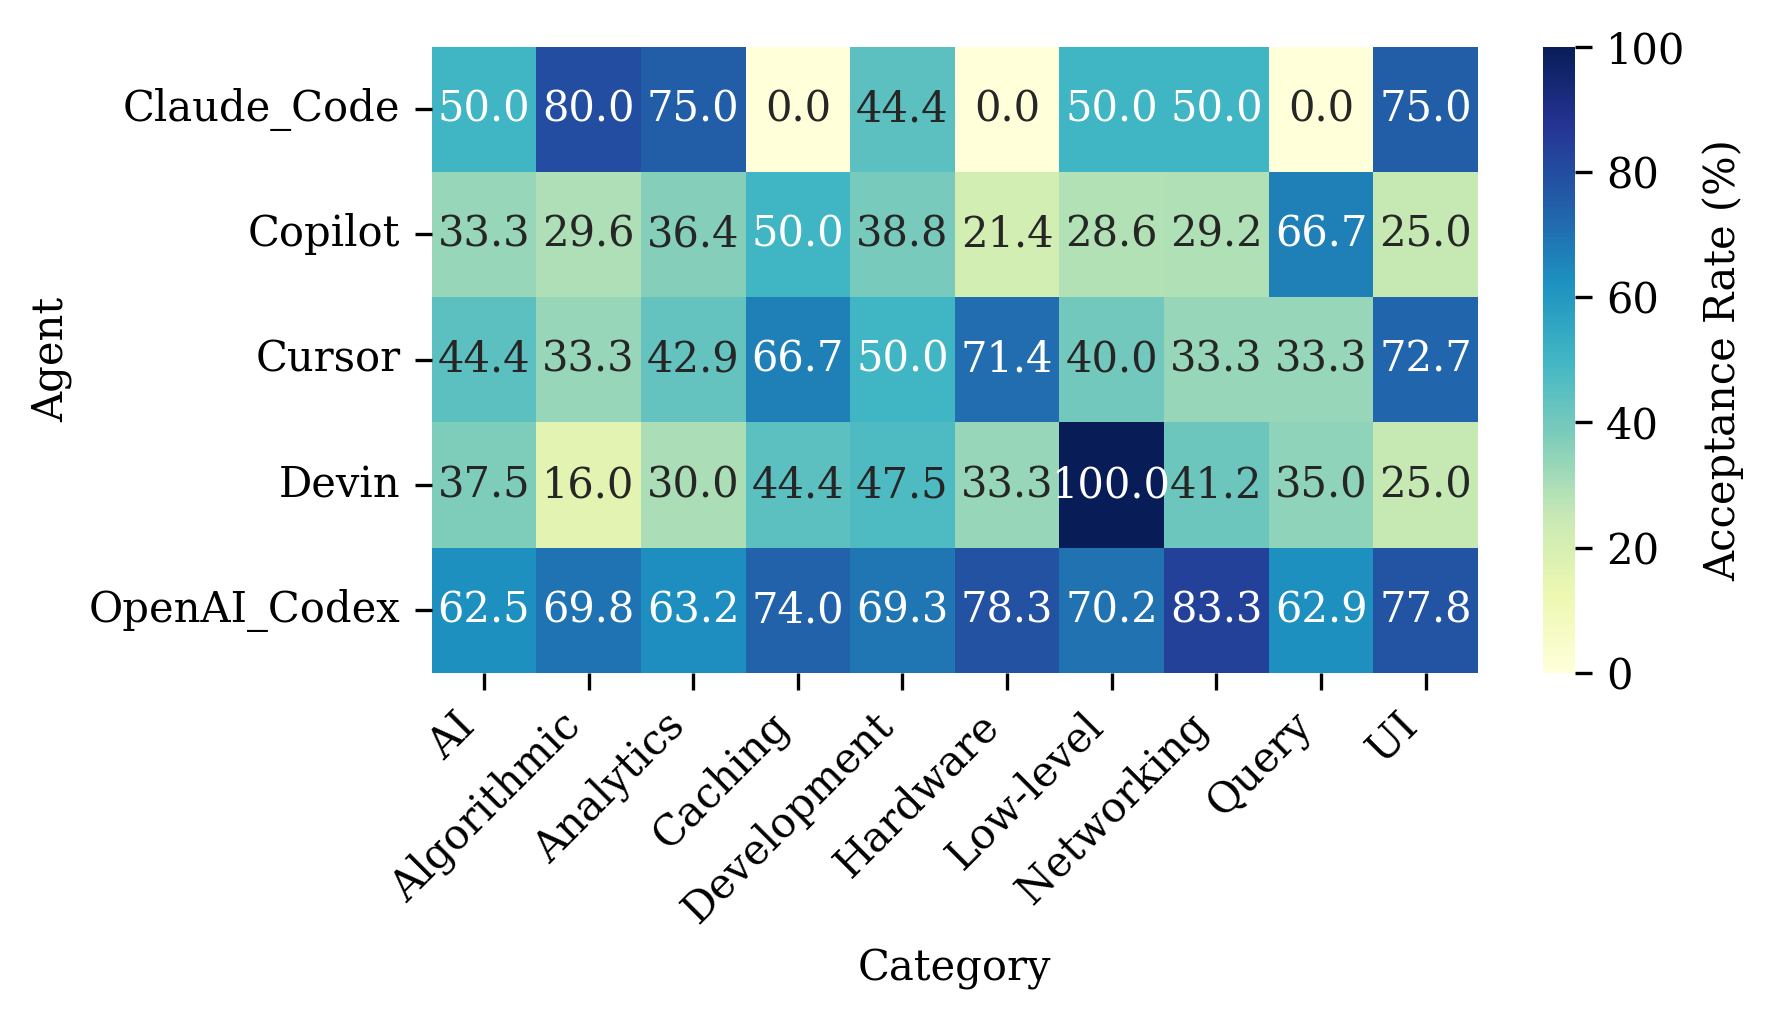

In [25]:
# Visualize acceptance rates as a heatmap
pivot_acceptance = acceptance_df.pivot(index='agent', columns='category', values='acceptance_rate')

fig = plt.figure(figsize=(6, 3.5))
sns.heatmap(pivot_acceptance, annot=True, fmt='.1f', cmap='YlGnBu', cbar_kws={'label': 'Acceptance Rate (%)'})
#plt.title('Acceptance Rates (%) per Agent per Category')
plt.xlabel('Category')
plt.ylabel('Agent')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('./Outputs/Figures/RQ4_Acceptance_Rates_Heatmap.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [21]:
# Pairwise Wilcoxon rank-sum test on acceptance rates
from itertools import combinations

agents = sorted(all_categories_df['agent'].unique())
pairwise_results = []

for agent1, agent2 in combinations(agents, 2):
    # Get acceptance rates for each agent across all categories
    rates_agent1 = acceptance_df[acceptance_df['agent'] == agent1]['acceptance_rate'].values
    rates_agent2 = acceptance_df[acceptance_df['agent'] == agent2]['acceptance_rate'].values
    
    # Wilcoxon rank-sum test (Mann-Whitney U test)
    statistic, p_value = ranksums(rates_agent1, rates_agent2)
    
    # Cliff's Delta for effect size
    cliff_delta_result = CliffsDelta.cliffsDelta(rates_agent1, rates_agent2)
    cliff_delta_value = cliff_delta_result[0]
    magnitude = cliff_delta_result[1]
    
    # Determine which agent has higher acceptance rate
    mean_agent1 = np.mean(rates_agent1)
    mean_agent2 = np.mean(rates_agent2)
    higher_agent = agent1 if mean_agent1 > mean_agent2 else agent2
    
    pairwise_results.append({
        'Agent 1': agent1,
        'Agent 2': agent2,
        'Mean Rate Agent 1': mean_agent1,
        'Mean Rate Agent 2': mean_agent2,
        'Higher Agent': higher_agent,
        'Statistic': statistic,
        'p-value': p_value,
        'Significant (p<0.05)': 'Yes' if p_value < 0.05 else 'No',
        'Cliff\'s Delta': cliff_delta_value,
        'Magnitude': magnitude
    })

pairwise_df = pd.DataFrame(pairwise_results)
pairwise_df

,Agent 1,Agent 2,Mean Rate Agent 1,Mean Rate Agent 2,Higher Agent,Statistic,p-value,Significant (p<0.05),Cliff's Delta,Magnitude
0,Claude_Code,Copilot,42.444444,35.896590,Claude_Code,1.020504,0.307489,No,0.27,small
1,Claude_Code,Cursor,42.444444,48.812410,Cursor,0.377964,0.705457,No,0.10,negligible
2,Claude_Code,Devin,42.444444,40.995425,Claude_Code,0.869318,0.384673,No,0.23,small
3,Claude_Code,OpenAI_Codex,42.444444,71.122929,OpenAI_Codex,-2.041008,0.041250,Yes,-0.54,large
4,Copilot,Cursor,35.896590,48.812410,Cursor,-2.154397,0.031209,Yes,-0.57,large
5,Copilot,Devin,35.896590,40.995425,Devin,-0.680336,0.496292,No,-0.18,small
6,Copilot,OpenAI_Codex,35.896590,71.122929,OpenAI_Codex,-3.552866,0.000381,Yes,-0.94,large
7,Cursor,Devin,48.812410,40.995425,Cursor,1.285079,0.198765,No,0.34,medium
8,Cursor,OpenAI_Codex,48.812410,71.122929,OpenAI_Codex,-2.645751,0.008151,Yes,-0.70,large
9,Devin,OpenAI_Codex,40.995425,71.122929,OpenAI_Codex,-3.023716,0.002497,Yes,-0.80,large
